# Extract Time Series Sentinel-2 data
## from Digital Earth Australia (DEA) via STAC

In [10]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon

import pystac_client
import odc.stac
# odc-stac library downloads DEA datasets stored in AWS
# when external to AWS (like outside DEA sandbox), AWS signed requests must be disabled
os.environ['AWS_NO_SIGN_REQUEST'] = 'YES'

from datacube.utils.geometry import CRS, Geometry, BoundingBox
from datacube.model import GridSpec

# My helper class
from dea_helperfunctions import DEA_HelperFunctions

### DEA Open Data Cube Query Parameters (Constants)

In [11]:
# configure helper functions
dea_fns = DEA_HelperFunctions()

# Area North East of Mallala,SA
#survey_origin = [ 138.43623157814235, -34.48646411817517 ] # bottom left (South West) corner of Survey area
survey_origin = [ 151.21490708987315, -33.85855385016139 ] # Sydney Royal Botanic Gardens

# Survey Area (Region of Interest)
epsg3577 = 'EPSG:3577'            # EPSG:3577: GDA94 / Australian Albers projection
pixel_resolution = (-10,10)       # Each pixel is of 10m x 10m resolution
survey_tilesize = (5120,5120)     # size of each tile in metres
survey_tiles = (5,5)              # number of horizontal and vertical tiles

# Satellite datasets
collections = ["s2a_ard_granule", "s2b_ard_granule"] # Sentinel-2A and 2B MSI Definitive ARD - NBART and Pixel Quality
bands = ("nbart_blue", "nbart_green", "nbart_red", "nbart_nir_1") # Satellite Bands

### Define Survey Area Grid Tiles

In [12]:
# Subdivide survey area into tiles
surveyarea_polygons = dea_fns.calc_surveyarea_polygons( origin=survey_origin,
                                                       tileresolution=survey_tilesize,
                                                       numtiles=survey_tiles)
#print(surveyarea_polygons)
print(surveyarea_polygons[0])

POLYGON ((151.2149070898732 -33.85855385016139, 151.2149070898732 -33.81250858393835, 151.2703555576214 -33.81250858393835, 151.2703555576214 -33.85855385016139, 151.2149070898732 -33.85855385016139))


#### Alternate method

In [13]:
# Define Grid Specification for a specific CRS, tile size and pixel resolution
survey_grid = GridSpec( crs=CRS(epsg3577), 
                        tile_size=survey_tilesize, 
                        resolution=pixel_resolution,
                        origin=(0.0,0.0))
print(survey_grid)
print(survey_grid.alignment)
print(survey_grid.dimensions)
print(survey_grid.tile_resolution)

GridSpec(crs=EPSG:3577, tile_size=(5120, 5120), resolution=(-10, 10))
(0.0, 0.0)
('y', 'x')
(512, 512)


In [14]:
# TEST CODE
# Apply Grid to Survey Area
surveyarea_polygon = dea_fns.calc_surveyarea_polygon( origin=survey_origin,
                                                       tileresolution=survey_tilesize,
                                                       numtiles=survey_tiles)
#print(surveyarea_polygon)

list(survey_grid.tiles(BoundingBox(151.2149070898732, -33.85855385016139, 151.4914033431495, -33.62832751904619)))

[((0, -1),
  GeoBox(512, 512, Affine(10.0, 0.0, 0.0,
         0.0, -10.0, 0.0), EPSG:3577))]

### Plot tiles

In [15]:
gdf_surveyarea = gpd.GeoDataFrame(columns=["tile", "geometry"])

tilenum = 0
for surveyarea_polygon in surveyarea_polygons:
    tilenum +=1
    gdf_surveyarea.loc[tilenum] = (tilenum,surveyarea_polygon)

gdf_surveyarea

,tile,geometry
1,1,"POLYGON ((151.21491 -33.85855, 151.21491 -33.8..."
2,2,"POLYGON ((151.27036 -33.85855, 151.27036 -33.8..."
3,3,"POLYGON ((151.32580 -33.85855, 151.32580 -33.8..."
4,4,"POLYGON ((151.38125 -33.85855, 151.38125 -33.8..."
5,5,"POLYGON ((151.43670 -33.85855, 151.43670 -33.8..."
6,6,"POLYGON ((151.21491 -33.81251, 151.21491 -33.7..."
7,7,"POLYGON ((151.27036 -33.81251, 151.27036 -33.7..."
8,8,"POLYGON ((151.32580 -33.81251, 151.32580 -33.7..."
9,9,"POLYGON ((151.38125 -33.81251, 151.38125 -33.7..."
10,10,"POLYGON ((151.43670 -33.81251, 151.43670 -33.7..."


<AxesSubplot:>

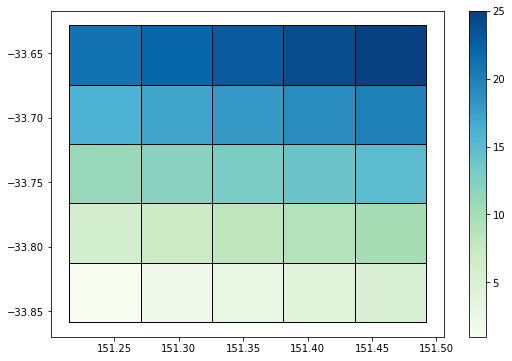

In [21]:
gdf_surveyarea.plot(column="tile", kind='geo', figsize=(9,6), cmap='GnBu', legend=True, edgecolor="black")

### Open Catalog

In [22]:
catalog = pystac_client.Client.open('https://explorer.sandbox.dea.ga.gov.au/stac')
#print('COLLECTIONS')
#print('===========')
#for collection in catalog.get_collections():
#    print(collection.id)

In [ ]:
# Convert GeoDataFrame polygons to bbox iteratable
# gdf_surveyarea -> sae_bbox or sae_geom

# Iterate through each GeoDataFrame polygon
# Extract bands for each polygon for each time period specified
timebands = [[("2022-03-22","2022-03-26")],[("2022-04-22","2022-04-26")]] # start-date, end-date pairs
surveyarea_ds = []

for t in timebands:
    i=0
    for p in surveyarea_polygons:
        i+=1
        p_bbox = convert_poly2bbox(p)
        
        query = catalog.search( bbox=p_bbox, collections=collections, datetime=f"{t[0]}/{t[1]}" )
        items = list(query.get_items()) # Search the STAC catalog
        
        print(f"Time band: {t}")
        print(f"Tile #: {i}")
        print(f"Found: {len(items):d} datasets")
        
        ds = odc.stac.load( items, bands=bands, crs=epsg3577, resolution=pixel_resolution, chunks={}, groupby="solar_day", bbox=p_bbox)
        surveyarea_ds.append({t, p, ds})

In [ ]:
# Build a query with the set parameters
#query = catalog.search(
#    bbox=sae_bbox,
#    intersects=sae_geom
#    collections=collections,
#    datetime=f"{start_date}/{end_date}"
#)


# Search the STAC catalog for all items matching the query
#items = list(query.get_items())
#print(f"Found: {len(items):d} datasets")

#ds = odc.stac.load(
#    items,
#    bands=bands,
#    crs=epsg3577,
#    resolution=pixel_resolution,
#    chunks={},
#    groupby="solar_day",
#    bbox=sae_bbox,
#)

# ds.nbart_nir_1

In [ ]:
# refer to https://xarray.pydata.org/en/stable/generated/xarray.plot.plot.html?highlight=plot
# to tweak plots
#ds.nbart_blue.plot(col='time', aspect=ds.dims["x"] / ds.dims["y"]);
#ds.nbart_green.plot(col='time', aspect=ds.dims["x"] / ds.dims["y"]);
#ds.nbart_red.plot(col='time', aspect=ds.dims["x"] / ds.dims["y"]);
#ds.nbart_nir_1.plot(col='time', aspect=ds.dims["x"] / ds.dims["y"]);